In [1]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from os import listdir
import datetime

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import r2_score
from joblib import dump, load

In [2]:
stocks = ["aapl.csv", "nke.csv", "pfe.csv", "ko.csv", "dis.csv"]
input_data = []
for stock in stocks:
    NAME = stock.split(".")[0].upper()
    folder = "prepared_stock_data"
    data = pd.read_csv(folder + "//" + stock, index_col = "Unnamed: 0").drop(['Label'],axis=1)
    folder = "stock_data"
    prices = pd.read_csv(folder + "//" + stock, index_col = "Date")["Close"]
    prices = prices.loc["2019-01-01":"2020-01-01"]
    data = data.loc["2019-01-01":"2020-01-01"]
    dates = data.index
    X = np.asanyarray(data.drop("Name", axis = 1))
    X = torch.tensor(X).float()
    input_data.append((NAME, X, prices))
    print(NAME, X[:1,:], prices.head(3))

AAPL tensor([[-0.1075, -0.1235, -0.1198, -0.1133, -0.1133, -0.1130, -0.0992, -0.0860,
         -0.0761, -0.0502, -0.0579, -0.0596, -0.0530, -0.0118,  0.0154, -0.0361,
         -0.0192, -0.0032, -0.0122, -0.0332, -0.1317, -0.0971, -0.1660, -0.1841,
         -0.1769, -0.2501, -0.3195, -0.3161, -0.2639, -0.1236, -0.0166]]) Date
2019-01-02    154.79
2019-01-03    139.38
2019-01-04    145.33
Name: Close, dtype: float64
NKE tensor([[ 0.1562,  0.1503,  0.1271,  0.1061,  0.1064,  0.0932,  0.0805,  0.0794,
          0.0854,  0.0906,  0.0906,  0.0877,  0.0951,  0.1049,  0.1783,  0.1299,
          0.1234,  0.1545,  0.1164,  0.1180,  0.1011,  0.0942,  0.0771, -0.0213,
         -0.0476, -0.0706, -0.0803, -0.1343, -0.0008,  0.0097, -0.0159]]) Date
2019-01-02    72.90
2019-01-03    71.61
2019-01-04    73.48
Name: Close, dtype: float64
PFE tensor([[ 0.2128,  0.2014,  0.2010,  0.2106,  0.2128,  0.2074,  0.2081,  0.1975,
          0.1453,  0.1690,  0.1777,  0.2088,  0.2092,  0.2132,  0.2953,  0.2597,
  

In [3]:
class DNN_Model1(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2, p=0.5):
        super(DNN_Model1, self).__init__()
        self.drop = nn.Dropout(p = p)
        self.channel1_l1 = nn.Linear(D_in, H1)
        self.channel1_l2 = nn.Linear(H1, H2)
        self.channel1_l3 = nn.Linear(H2, H3)
        
        self.channel2_l1 = nn.Linear(D_in, H1)
        self.channel2_l2 = nn.Linear(H1, H2)
        self.channel2_l3 = nn.Linear(H2, H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.drop(self.channel1_l1(x)), self.drop(self.channel2_l1(x)))
        x = torch.max(self.drop(self.channel1_l2(x)), self.drop(self.channel2_l2(x)))
        x = torch.max(self.drop(self.channel1_l3(x)), self.drop(self.channel2_l3(x)))
        x = F.softmax(self.out(x))
        return x

In [4]:
class DNN_Carlos(nn.Module):
    def __init__(self, D_in, H1, H2, H3, D_out=2):
        super(DNN_Carlos, self).__init__()
        self.drop1 = nn.Dropout(p = 0.5)
        self.drop2 = nn.Dropout(p = 0.25)
        
        self.linear1_1 = nn.Linear(D_in, H1)
        torch.nn.init.kaiming_uniform_(self.linear1_1.weight, nonlinearity = "leaky_relu")
        self.linear2_1 = nn.Linear(H1, H2)
        torch.nn.init.kaiming_uniform_(self.linear2_1.weight, nonlinearity = "leaky_relu")
        self.linear3_1 = nn.Linear(H2, H3)
        torch.nn.init.kaiming_uniform_(self.linear3_1.weight, nonlinearity = "leaky_relu")
        self.linear1_2 = nn.Linear(D_in, H1)
        torch.nn.init.kaiming_uniform_(self.linear1_2.weight, nonlinearity = "leaky_relu")
        self.linear2_2 = nn.Linear(H1, H2)
        torch.nn.init.kaiming_uniform_(self.linear2_2.weight, nonlinearity = "leaky_relu")
        self.linear3_2 = nn.Linear(H2, H3)
        torch.nn.init.kaiming_uniform_(self.linear3_2.weight, nonlinearity = "leaky_relu")
        
        self.bn1 = nn.BatchNorm1d(H1)
        self.bn2 = nn.BatchNorm1d(H2)
        self.bn3 = nn.BatchNorm1d(H3)
        
        self.out = nn.Linear(H3, D_out)

    def forward(self, x):
        x = torch.max(self.bn1(self.drop1(self.linear1_1(x))), self.bn1(self.drop1(self.linear1_2(x))))
        x = torch.max(self.bn2(self.drop2(self.linear2_1(x))), self.bn2(self.drop2(self.linear2_2(x))))
        x = torch.max(self.bn3(self.linear3_1(x)), self.bn3(self.linear3_2(x)))
        x = F.softmax(self.out(x))
        return x

In [5]:
def test_case(NAME, signals):
    budget = 100000
    investment = 0
    prevSignal = -1
    prevPrice = -1
    for i, date in enumerate(dates):
        inf = signals.loc[date]
        curSignal = inf["Signal"]
        curPrice = inf["Price"]
        if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
            investment += budget
            budget = 0
            prevPrice = curPrice
            #print(date, "BUY, INVESTMENT: $", np.round(investment,3), curPrice)
        elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
            budget = curPrice/prevPrice * investment
            investment = 0
            #print(date, "SELL, BUDGET   : $",np.round(budget,3), curPrice)
        prevSignal = curSignal

    print(NAME)
    print("final budget: $", budget)
    print("Return: ", budget/100000 - 1)
    return budget/100000 - 1

In [6]:
def test_case_fee(NAME, signals):
    budget = 100000
    investment = 0
    prevSignal = -1
    prevPrice = -1
    for i, date in enumerate(dates):
        inf = signals.loc[date]
        curSignal = inf["Signal"]
        curPrice = inf["Price"]
        if (curSignal == 0) and (prevSignal != 0) and i < len(dates)-1:
            investment += budget * 0.999
            budget = 0
            prevPrice = curPrice
            print(date, "BUY, INVESTMENT: $", np.round(investment,3), curPrice)
        elif investment > 0 and (((curSignal == 1) and (prevSignal == 0)) or i == len(dates)-1):
            budget = curPrice/prevPrice * investment * 0.999
            investment = 0
            print(date, "SELL, BUDGET   : $",np.round(budget,3), curPrice)
        prevSignal = curSignal

    print(NAME)
    print("final budget: $", budget)
    print("Return: ", budget/100000 - 1)
    return budget/100000 - 1

In [7]:
def plot_trading(NAME, MODEL, signals, RETURN):
    information = signals.loc["2019-01-01":"2019-08-01"]
    plt.figure(figsize = (14,7))
    plt.title(NAME + " " + MODEL +" Signals. Return: " + str(RETURN), fontsize = 8)
    plt.plot(information["Price"], color = "gray", label = "Closing Price")
    plt.plot(information["Price"][information["Signal"] == 1], 'v', color = 'r', label = "SELL")
    plt.plot(information["Price"][information["Signal"] == 0], '^', color = 'g', label = "BUY")
    plt.legend()

    plt.xticks(information.index[::15], fontsize = 16, rotation = 45)
    plt.yticks(fontsize = 16)
    plt.show()

In [8]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
dropout_rate = 0.5

In [9]:
PATH = "models//model1_2019.pth"
DNN_model = DNN_Model1(input_dim, hidden1, hidden2, hidden3, out_dim, dropout_rate)
DNN_model.load_state_dict(torch.load(PATH))
DNN_model.eval()

DNN_Model1(
  (drop): Dropout(p=0.5, inplace=False)
  (channel1_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel1_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel1_l3): Linear(in_features=10, out_features=5, bias=True)
  (channel2_l1): Linear(in_features=31, out_features=31, bias=True)
  (channel2_l2): Linear(in_features=31, out_features=10, bias=True)
  (channel2_l3): Linear(in_features=10, out_features=5, bias=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

In [10]:
input_dim = 31
hidden1 = 31
hidden2 = 10
hidden3 = 5
out_dim = 2
DNNCarlos_Model = DNN_Carlos(input_dim, hidden1, hidden2, hidden3, out_dim)

In [11]:
PATH = "models//modelCarlos_2019.pth"
DNNCarlos_Model.load_state_dict(torch.load(PATH))
DNNCarlos_Model.eval()

DNN_Carlos(
  (drop1): Dropout(p=0.5, inplace=False)
  (drop2): Dropout(p=0.25, inplace=False)
  (linear1_1): Linear(in_features=31, out_features=31, bias=True)
  (linear2_1): Linear(in_features=31, out_features=10, bias=True)
  (linear3_1): Linear(in_features=10, out_features=5, bias=True)
  (linear1_2): Linear(in_features=31, out_features=31, bias=True)
  (linear2_2): Linear(in_features=31, out_features=10, bias=True)
  (linear3_2): Linear(in_features=10, out_features=5, bias=True)
  (bn1): BatchNorm1d(31, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=5, out_features=2, bias=True)
)

## Deep Neural Network Model Returns

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AAPL
final budget: $ 136293.86042209459
Return:  0.3629386042209459


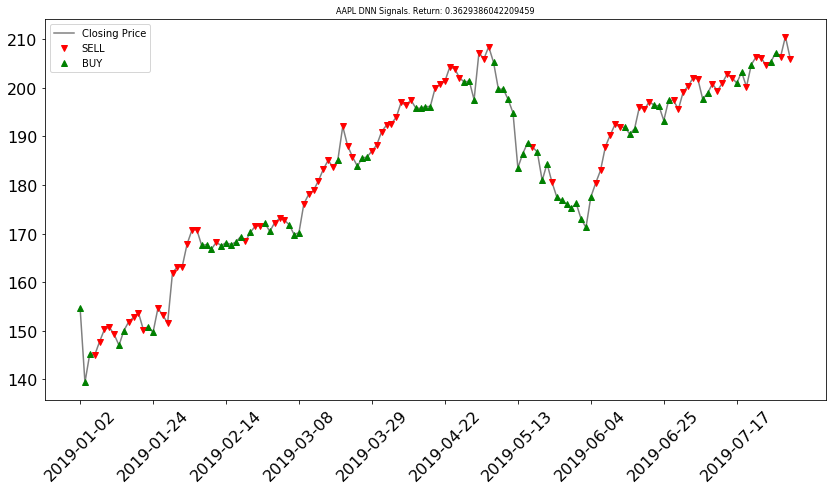

NKE
final budget: $ 118188.33837272355
Return:  0.18188338372723556


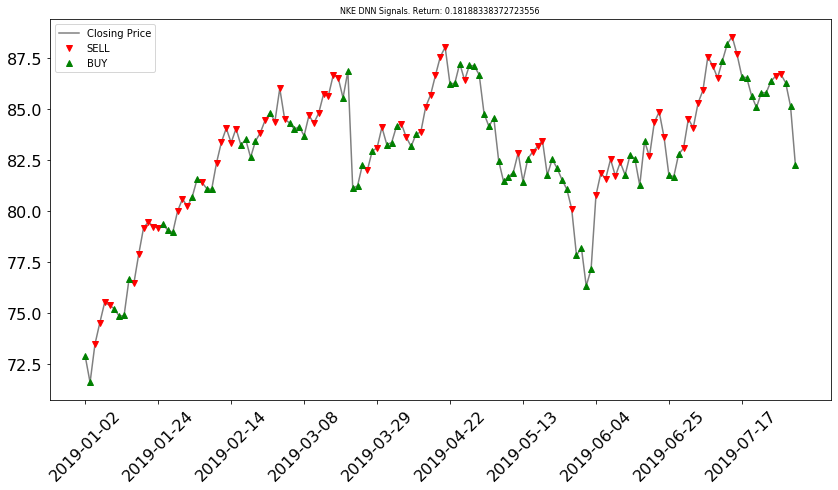

PFE
final budget: $ 87352.79122052499
Return:  -0.12647208779475017


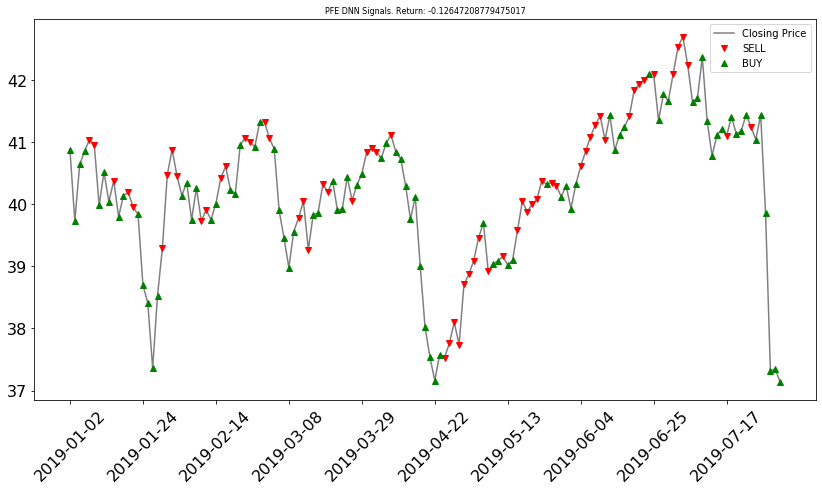

KO
final budget: $ 119348.1907649197
Return:  0.19348190764919693


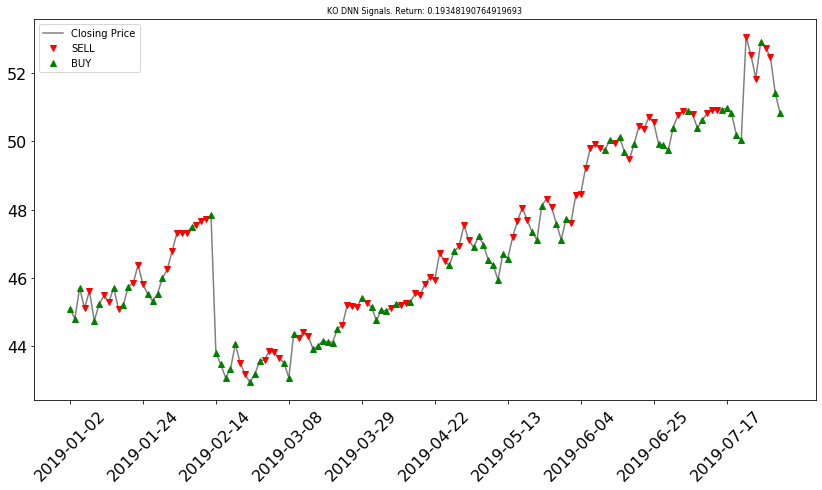

DIS
final budget: $ 130788.42572895045
Return:  0.3078842572895044


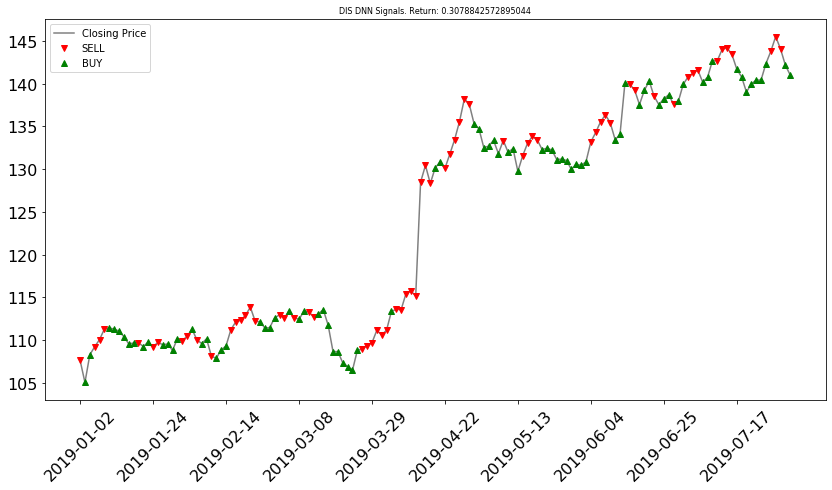

2019-01-02 BUY, INVESTMENT: $ 99900.0 154.79
2019-01-07 SELL, BUDGET   : $ 93488.045 145.0
2019-01-14 BUY, INVESTMENT: $ 93394.557 147.03
2019-01-16 SELL, BUDGET   : $ 96372.492 151.87
2019-01-23 BUY, INVESTMENT: $ 96276.12 150.87
2019-01-25 SELL, BUDGET   : $ 98583.224 154.64
2019-02-07 BUY, INVESTMENT: $ 98484.641 167.56
2019-02-12 SELL, BUDGET   : $ 98779.56 168.23
2019-02-13 BUY, INVESTMENT: $ 98680.78 167.53
2019-02-21 SELL, BUDGET   : $ 99088.162 168.39
2019-02-22 BUY, INVESTMENT: $ 98989.074 170.27
2019-02-25 SELL, BUDGET   : $ 99610.257 171.51
2019-02-27 BUY, INVESTMENT: $ 99510.647 172.14
2019-03-01 SELL, BUDGET   : $ 99468.886 172.24
2019-03-06 BUY, INVESTMENT: $ 99369.417 171.8
2019-03-11 SELL, BUDGET   : $ 101760.466 176.11
2019-03-20 BUY, INVESTMENT: $ 101658.706 185.23
2019-03-21 SELL, BUDGET   : $ 105296.285 192.05
2019-03-26 BUY, INVESTMENT: $ 105190.989 183.88
2019-03-29 SELL, BUDGET   : $ 106863.135 186.99
2019-04-11 BUY, INVESTMENT: $ 106756.272 195.85
2019-04-17 SEL

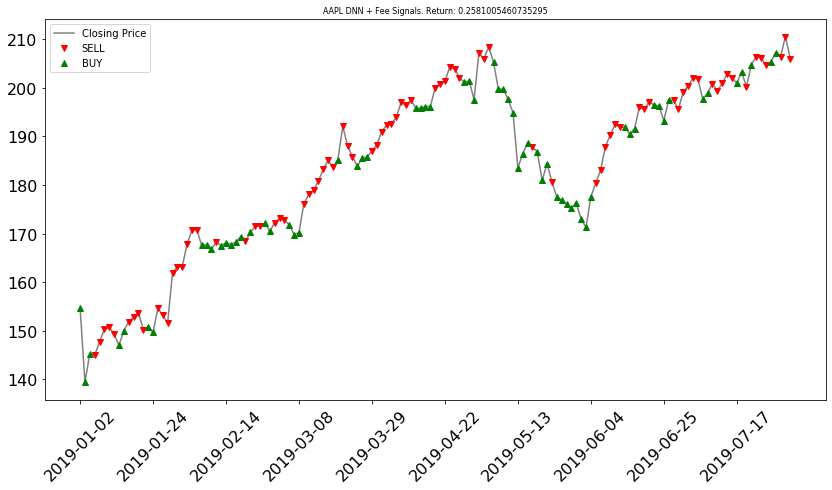

2019-01-02 BUY, INVESTMENT: $ 99900.0 72.9
2019-01-04 SELL, BUDGET   : $ 100594.12 73.48
2019-01-10 BUY, INVESTMENT: $ 100493.526 75.22
2019-01-16 SELL, BUDGET   : $ 102048.009 76.46
2019-01-25 BUY, INVESTMENT: $ 101945.961 79.35
2019-01-30 SELL, BUDGET   : $ 102691.111 80.01
2019-02-04 BUY, INVESTMENT: $ 102588.42 80.7
2019-02-06 SELL, BUDGET   : $ 103387.504 81.41
2019-02-07 BUY, INVESTMENT: $ 103284.116 81.1
2019-02-11 SELL, BUDGET   : $ 104796.611 82.37
2019-02-19 BUY, INVESTMENT: $ 104691.814 83.24
2019-02-25 SELL, BUDGET   : $ 105340.994 83.84
2019-02-27 BUY, INVESTMENT: $ 105235.653 84.82
2019-02-28 SELL, BUDGET   : $ 104597.452 84.39
2019-03-05 BUY, INVESTMENT: $ 104492.855 84.32
2019-03-11 SELL, BUDGET   : $ 104846.423 84.69
2019-03-20 BUY, INVESTMENT: $ 104741.577 85.55
2019-03-27 SELL, BUDGET   : $ 100294.804 82.0
2019-03-28 BUY, INVESTMENT: $ 100194.509 82.94
2019-03-29 SELL, BUDGET   : $ 100287.407 83.1
2019-04-02 BUY, INVESTMENT: $ 100187.12 83.26
2019-04-05 SELL, BUDGET 

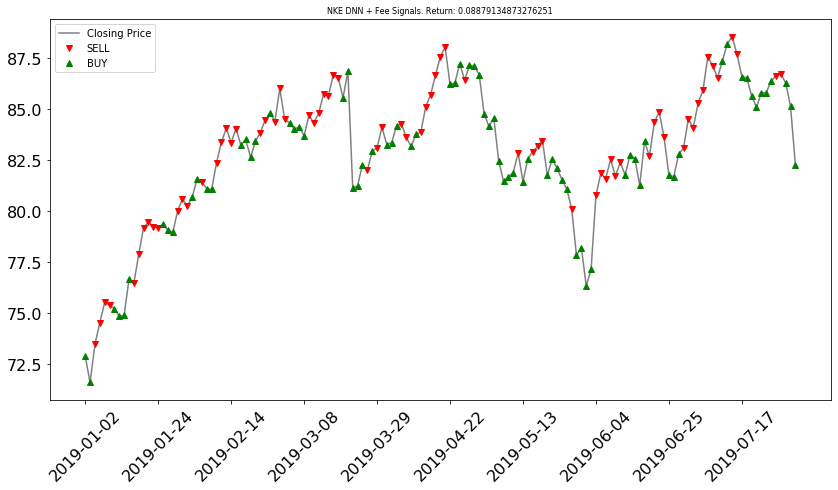

2019-01-02 BUY, INVESTMENT: $ 99900.0 40.87
2019-01-08 SELL, BUDGET   : $ 100215.222 41.04
2019-01-10 BUY, INVESTMENT: $ 100115.006 39.98
2019-01-15 SELL, BUDGET   : $ 101015.541 40.38
2019-01-16 BUY, INVESTMENT: $ 100914.525 39.8
2019-01-18 SELL, BUDGET   : $ 101801.483 40.19
2019-01-23 BUY, INVESTMENT: $ 101699.681 39.84
2019-01-30 SELL, BUDGET   : $ 100195.399 39.29
2019-02-05 BUY, INVESTMENT: $ 100095.203 40.14
2019-02-11 SELL, BUDGET   : $ 98973.733 39.73
2019-02-13 BUY, INVESTMENT: $ 98874.759 39.75
2019-02-15 SELL, BUDGET   : $ 100440.786 40.42
2019-02-20 BUY, INVESTMENT: $ 100340.346 40.23
2019-02-25 SELL, BUDGET   : $ 102333.011 41.07
2019-02-27 BUY, INVESTMENT: $ 102230.678 40.92
2019-03-01 SELL, BUDGET   : $ 103151.728 41.33
2019-03-05 BUY, INVESTMENT: $ 103048.576 40.89
2019-03-12 SELL, BUDGET   : $ 100150.968 39.78
2019-03-15 BUY, INVESTMENT: $ 100050.817 39.83
2019-03-19 SELL, BUDGET   : $ 101180.389 40.32
2019-03-21 BUY, INVESTMENT: $ 101079.209 40.37
2019-03-27 SELL, BU

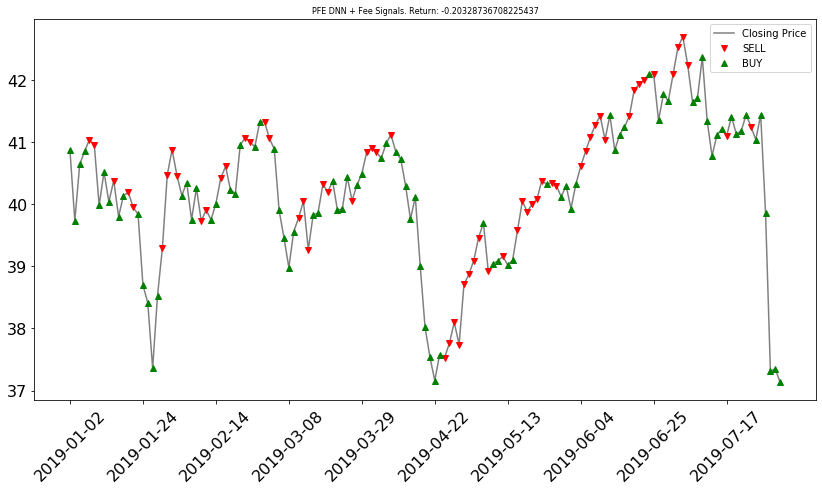

2019-01-02 BUY, INVESTMENT: $ 99900.0 45.09
2019-01-07 SELL, BUDGET   : $ 99844.367 45.11
2019-01-09 BUY, INVESTMENT: $ 99744.523 44.75
2019-01-11 SELL, BUDGET   : $ 101292.535 45.49
2019-01-15 BUY, INVESTMENT: $ 101191.243 45.71
2019-01-16 SELL, BUDGET   : $ 99696.774 45.08
2019-01-17 BUY, INVESTMENT: $ 99597.077 45.22
2019-01-22 SELL, BUDGET   : $ 100883.668 45.85
2019-01-25 BUY, INVESTMENT: $ 100782.784 45.52
2019-01-31 SELL, BUDGET   : $ 102296.629 46.25
2019-02-07 BUY, INVESTMENT: $ 102194.332 47.49
2019-02-08 SELL, BUDGET   : $ 102242.621 47.56
2019-02-13 BUY, INVESTMENT: $ 102140.379 47.84
2019-02-22 SELL, BUDGET   : $ 92802.754 43.51
2019-02-26 BUY, INVESTMENT: $ 92709.951 42.94
2019-03-01 SELL, BUDGET   : $ 94040.795 43.6
2019-03-07 BUY, INVESTMENT: $ 93946.754 43.51
2019-03-12 SELL, BUDGET   : $ 95449.017 44.25
2019-03-15 BUY, INVESTMENT: $ 95353.568 43.91
2019-03-25 SELL, BUDGET   : $ 96776.792 44.61
2019-03-29 BUY, INVESTMENT: $ 96680.015 45.42
2019-04-01 SELL, BUDGET   : $

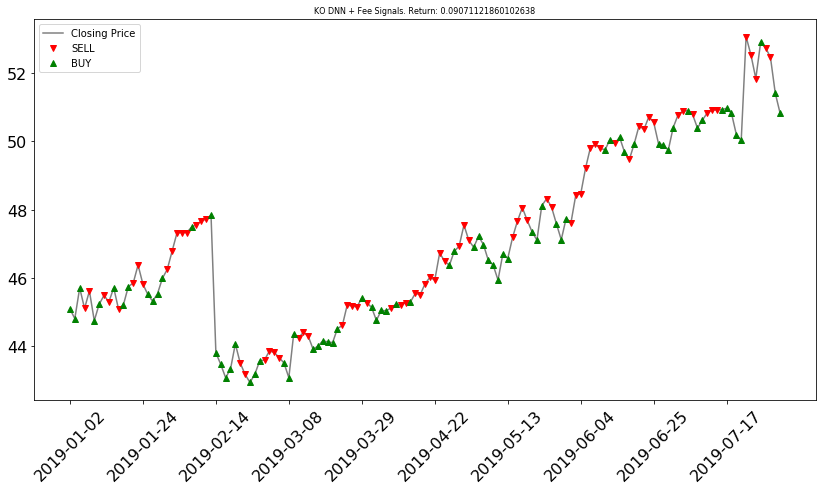

2019-01-03 BUY, INVESTMENT: $ 99900.0 105.05
2019-01-07 SELL, BUDGET   : $ 103771.203 109.23
2019-01-10 BUY, INVESTMENT: $ 103667.432 111.44
2019-01-18 SELL, BUDGET   : $ 101946.743 109.7
2019-01-22 BUY, INVESTMENT: $ 101844.796 109.26
2019-01-24 SELL, BUDGET   : $ 101705.703 109.22
2019-01-28 BUY, INVESTMENT: $ 101603.997 109.47
2019-02-01 SELL, BUDGET   : $ 101956.729 109.96
2019-02-05 BUY, INVESTMENT: $ 101854.773 111.3
2019-02-06 SELL, BUDGET   : $ 100619.283 110.06
2019-02-07 BUY, INVESTMENT: $ 100518.663 109.61
2019-02-11 SELL, BUDGET   : $ 99053.096 108.12
2019-02-12 BUY, INVESTMENT: $ 98954.042 107.88
2019-02-15 SELL, BUDGET   : $ 101924.838 111.23
2019-02-26 BUY, INVESTMENT: $ 101822.913 112.13
2019-03-04 SELL, BUDGET   : $ 102464.97 112.95
2019-03-06 BUY, INVESTMENT: $ 102362.505 113.46
2019-03-07 SELL, BUDGET   : $ 101512.074 112.63
2019-03-08 BUY, INVESTMENT: $ 101410.561 112.44
2019-03-12 SELL, BUDGET   : $ 102120.057 113.34
2019-03-14 BUY, INVESTMENT: $ 102017.937 113.1
2

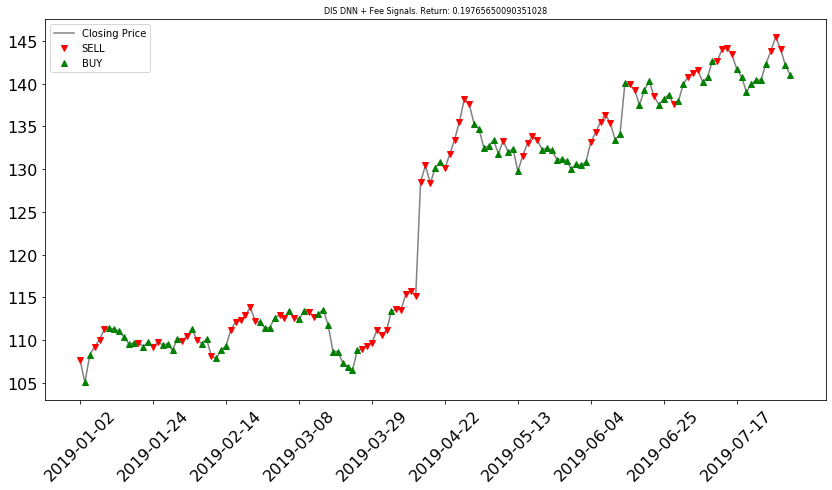

In [12]:
output_data = []
for NAME, X, PRICES in input_data:
    z = DNN_model(X)
    _, y_hat = torch.max(z,1)
    y_hat = y_hat.numpy()
    dates = PRICES.index
    signalsDNN = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsDNN))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, "DNN", signal, RETURN)
    
for NAME, signal in output_data:
    RETURN = test_case_fee(NAME, signal)
    plot_trading(NAME, "DNN + Fee", signal, RETURN)

## Carlos' DNN Model Returns

/home/cs582/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


AAPL
final budget: $ 159634.19207448748
Return:  0.5963419207448748


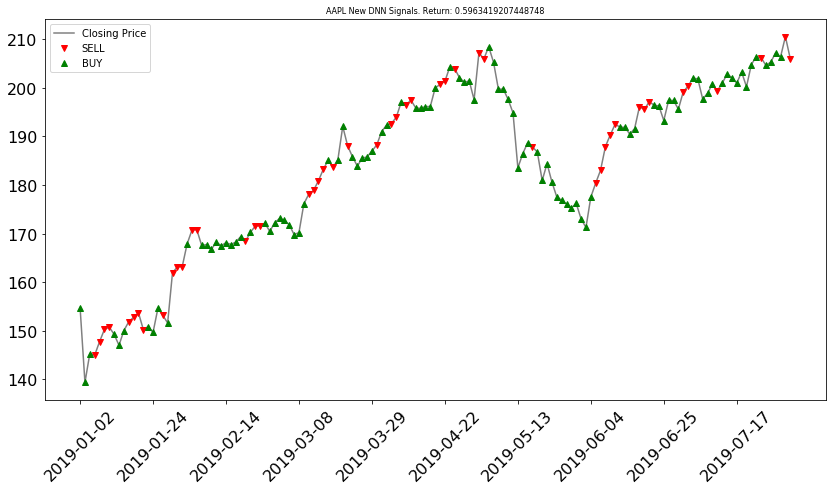

NKE
final budget: $ 145412.55022085944
Return:  0.4541255022085944


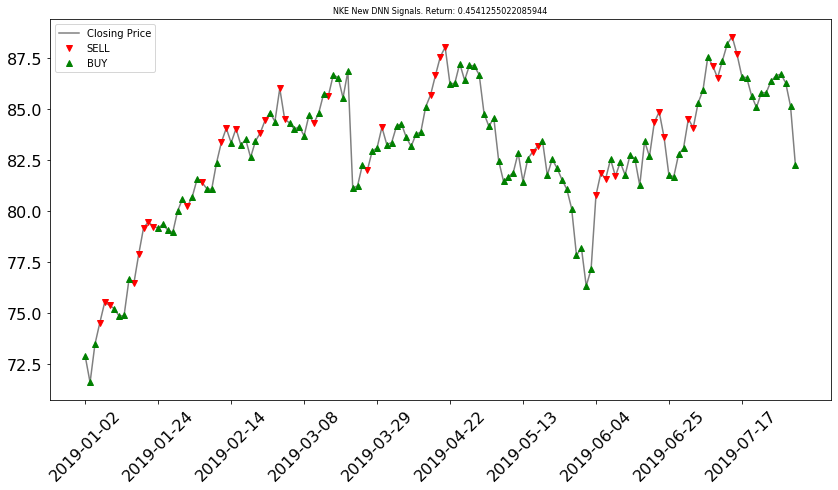

PFE
final budget: $ 92627.55115663091
Return:  -0.07372448843369084


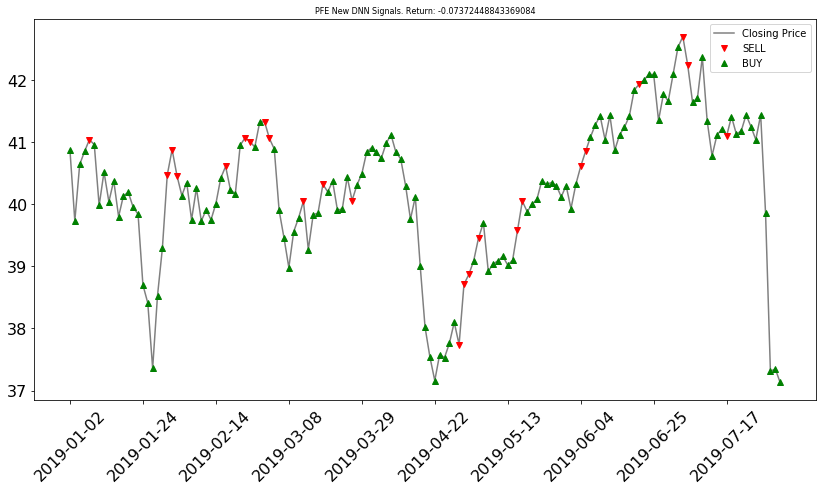

KO
final budget: $ 130537.89230666304
Return:  0.3053789230666304


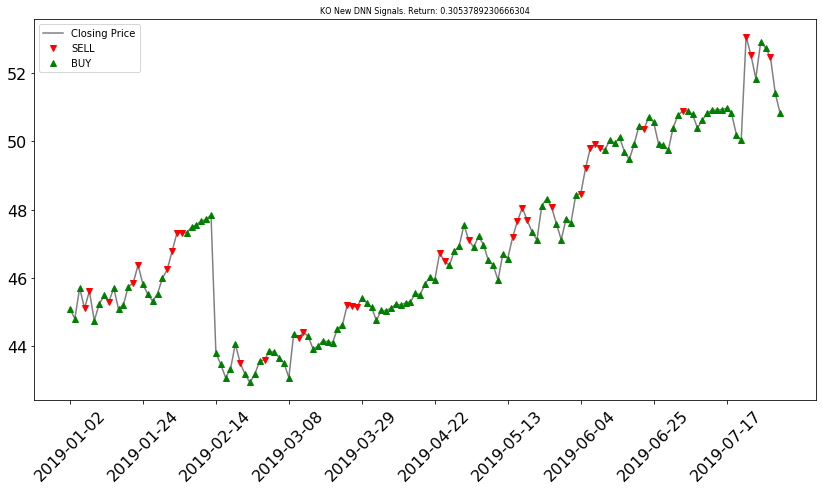

DIS
final budget: $ 124175.2860632213
Return:  0.24175286063221302


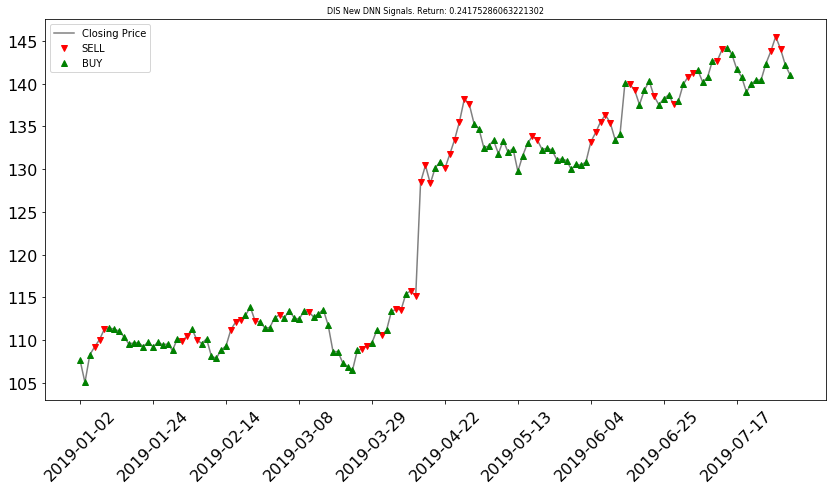

2019-01-02 BUY, INVESTMENT: $ 99900.0 154.79
2019-01-07 SELL, BUDGET   : $ 93488.045 145.0
2019-01-11 BUY, INVESTMENT: $ 93394.557 149.28
2019-01-16 SELL, BUDGET   : $ 94919.933 151.87
2019-01-23 BUY, INVESTMENT: $ 94825.013 150.87
2019-01-28 SELL, BUDGET   : $ 96199.457 153.21
2019-01-29 BUY, INVESTMENT: $ 96103.257 151.62
2019-01-30 SELL, BUDGET   : $ 102567.2 161.98
2019-02-04 BUY, INVESTMENT: $ 102464.633 167.86
2019-02-05 SELL, BUDGET   : $ 104112.313 170.73
2019-02-07 BUY, INVESTMENT: $ 104008.201 167.56
2019-02-21 SELL, BUDGET   : $ 104418.877 168.39
2019-02-22 BUY, INVESTMENT: $ 104314.458 170.27
2019-02-25 SELL, BUDGET   : $ 104969.059 171.51
2019-02-27 BUY, INVESTMENT: $ 104864.09 172.14
2019-03-12 SELL, BUDGET   : $ 108380.217 178.09
2019-03-18 BUY, INVESTMENT: $ 108271.837 185.09
2019-03-19 SELL, BUDGET   : $ 107304.521 183.62
2019-03-20 BUY, INVESTMENT: $ 107197.217 185.23
2019-03-22 SELL, BUDGET   : $ 108731.955 188.07
2019-03-25 BUY, INVESTMENT: $ 108623.223 185.8
2019-0

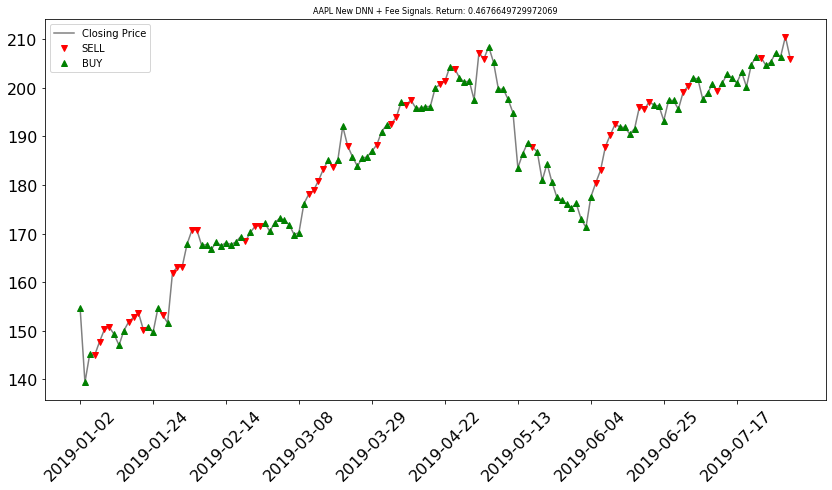

2019-01-02 BUY, INVESTMENT: $ 99900.0 72.9
2019-01-07 SELL, BUDGET   : $ 102031.57 74.53
2019-01-10 BUY, INVESTMENT: $ 101929.538 75.22
2019-01-16 SELL, BUDGET   : $ 103506.235 76.46
2019-01-24 BUY, INVESTMENT: $ 103402.728 79.18
2019-02-01 SELL, BUDGET   : $ 104669.17 80.23
2019-02-04 BUY, INVESTMENT: $ 104564.501 80.7
2019-02-06 SELL, BUDGET   : $ 105378.977 81.41
2019-02-07 BUY, INVESTMENT: $ 105273.598 81.1
2019-02-12 SELL, BUDGET   : $ 108124.968 83.38
2019-02-14 BUY, INVESTMENT: $ 108016.843 83.35
2019-02-15 SELL, BUDGET   : $ 108802.132 84.04
2019-02-19 BUY, INVESTMENT: $ 108693.33 83.24
2019-02-25 SELL, BUDGET   : $ 109367.323 83.84
2019-02-27 BUY, INVESTMENT: $ 109257.956 84.82
2019-03-01 SELL, BUDGET   : $ 110680.022 86.01
2019-03-05 BUY, INVESTMENT: $ 110569.342 84.32
2019-03-12 SELL, BUDGET   : $ 110445.673 84.31
2019-03-13 BUY, INVESTMENT: $ 110335.227 84.8
2019-03-15 SELL, BUDGET   : $ 111342.739 85.66
2019-03-18 BUY, INVESTMENT: $ 111231.396 86.67
2019-03-27 SELL, BUDGET

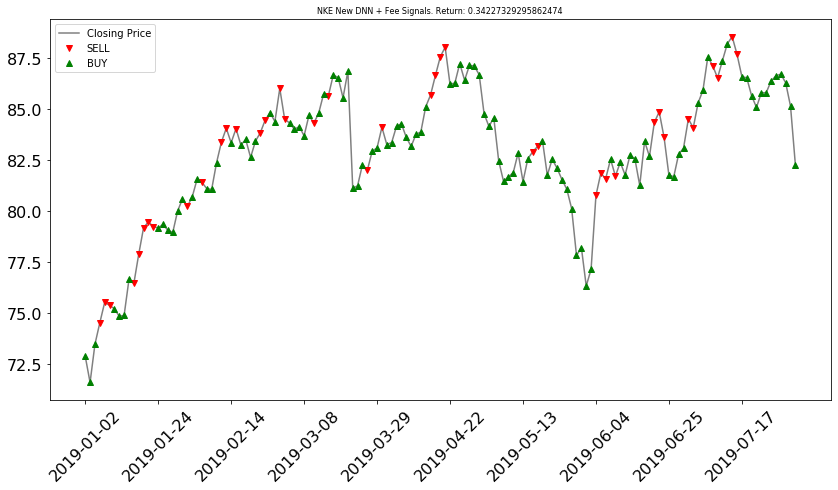

2019-01-02 BUY, INVESTMENT: $ 99900.0 40.87
2019-01-08 SELL, BUDGET   : $ 100215.222 41.04
2019-01-09 BUY, INVESTMENT: $ 100115.006 40.96
2019-01-31 SELL, BUDGET   : $ 98818.424 40.47
2019-02-05 BUY, INVESTMENT: $ 98719.606 40.14
2019-02-19 SELL, BUDGET   : $ 99775.64 40.61
2019-02-20 BUY, INVESTMENT: $ 99675.864 40.23
2019-02-25 SELL, BUDGET   : $ 101655.333 41.07
2019-02-27 BUY, INVESTMENT: $ 101553.678 40.92
2019-03-01 SELL, BUDGET   : $ 102468.629 41.33
2019-03-05 BUY, INVESTMENT: $ 102366.16 40.89
2019-03-13 SELL, BUDGET   : $ 100162.997 40.05
2019-03-14 BUY, INVESTMENT: $ 100062.834 39.27
2019-03-19 SELL, BUDGET   : $ 102635.573 40.32
2019-03-20 BUY, INVESTMENT: $ 102532.937 40.2
2019-03-27 SELL, BUDGET   : $ 102073.681 40.06
2019-03-28 BUY, INVESTMENT: $ 101971.608 40.31
2019-04-29 SELL, BUDGET   : $ 95374.847 37.74
2019-05-02 BUY, INVESTMENT: $ 95279.472 39.09
2019-05-03 SELL, BUDGET   : $ 96085.143 39.46
2019-05-06 BUY, INVESTMENT: $ 95989.058 39.7
2019-05-15 SELL, BUDGET   : 

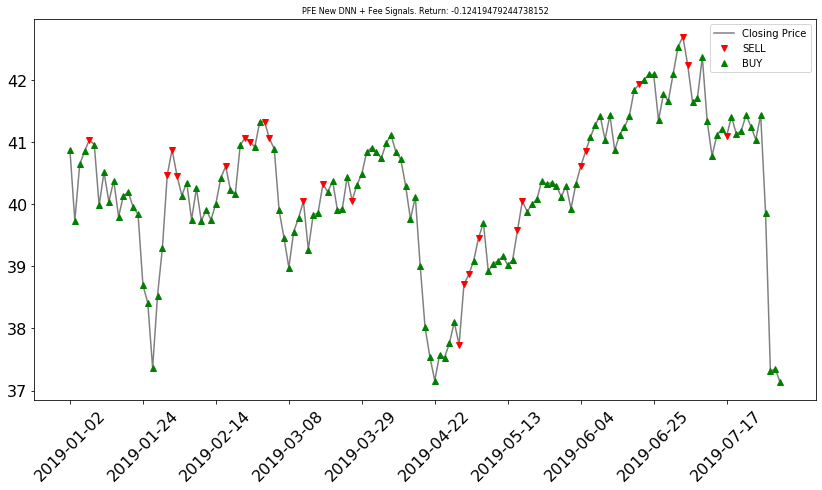

2019-01-02 BUY, INVESTMENT: $ 99900.0 45.09
2019-01-07 SELL, BUDGET   : $ 99844.367 45.11
2019-01-09 BUY, INVESTMENT: $ 99744.523 44.75
2019-01-14 SELL, BUDGET   : $ 100869.463 45.3
2019-01-15 BUY, INVESTMENT: $ 100768.593 45.71
2019-01-22 SELL, BUDGET   : $ 100976.149 45.85
2019-01-24 BUY, INVESTMENT: $ 100875.173 45.82
2019-01-31 SELL, BUDGET   : $ 101720.019 46.25
2019-02-06 BUY, INVESTMENT: $ 101618.299 47.33
2019-02-22 SELL, BUDGET   : $ 93323.278 43.51
2019-02-25 BUY, INVESTMENT: $ 93229.955 43.18
2019-03-01 SELL, BUDGET   : $ 94042.64 43.6
2019-03-04 BUY, INVESTMENT: $ 93948.598 43.86
2019-03-12 SELL, BUDGET   : $ 94689.198 44.25
2019-03-14 BUY, INVESTMENT: $ 94594.509 44.29
2019-03-26 SELL, BUDGET   : $ 96462.884 45.21
2019-03-29 BUY, INVESTMENT: $ 96366.421 45.42
2019-04-23 SELL, BUDGET   : $ 99046.668 46.73
2019-04-25 BUY, INVESTMENT: $ 98947.621 46.37
2019-05-01 SELL, BUDGET   : $ 100404.842 47.1
2019-05-02 BUY, INVESTMENT: $ 100304.437 46.9
2019-05-14 SELL, BUDGET   : $ 100

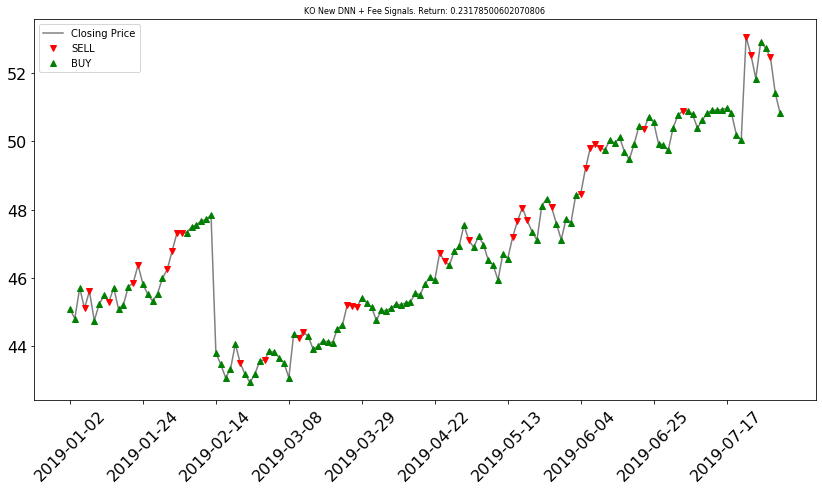

2019-01-02 BUY, INVESTMENT: $ 99900.0 107.65
2019-01-07 SELL, BUDGET   : $ 101264.885 109.23
2019-01-10 BUY, INVESTMENT: $ 101163.621 111.44
2019-02-01 SELL, BUDGET   : $ 99720.278 109.96
2019-02-05 BUY, INVESTMENT: $ 99620.558 111.3
2019-02-06 SELL, BUDGET   : $ 98412.168 110.06
2019-02-07 BUY, INVESTMENT: $ 98313.756 109.61
2019-02-15 SELL, BUDGET   : $ 99667.035 111.23
2019-02-21 BUY, INVESTMENT: $ 99567.368 112.91
2019-02-25 SELL, BUDGET   : $ 98859.946 112.22
2019-02-26 BUY, INVESTMENT: $ 98761.086 112.13
2019-03-04 SELL, BUDGET   : $ 99383.837 112.95
2019-03-05 BUY, INVESTMENT: $ 99284.453 112.62
2019-03-12 SELL, BUDGET   : $ 99819.277 113.34
2019-03-13 BUY, INVESTMENT: $ 99719.458 112.71
2019-03-27 SELL, BUDGET   : $ 96296.429 108.95
2019-03-29 BUY, INVESTMENT: $ 96200.133 109.69
2019-04-02 SELL, BUDGET   : $ 96909.982 110.61
2019-04-03 BUY, INVESTMENT: $ 96813.072 111.16
2019-04-05 SELL, BUDGET   : $ 98847.915 113.61
2019-04-09 BUY, INVESTMENT: $ 98749.067 115.45
2019-04-10 SEL

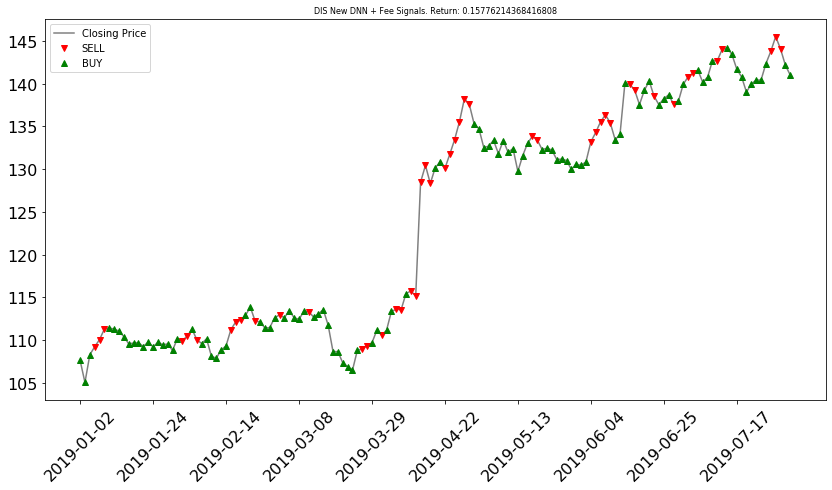

In [13]:
output_data = []
for NAME, X, PRICES in input_data:
    z = DNNCarlos_Model(X)
    _, y_hat = torch.max(z,1)
    y_hat = y_hat.numpy()
    dates = PRICES.index
    signalsDNNCarlos = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsDNNCarlos))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, "New DNN", signal, RETURN)

for NAME, signal in output_data:
    RETURN = test_case_fee(NAME, signal)
    plot_trading(NAME, "New DNN + Fee", signal, RETURN)

## Random Forest Model Returns

In [14]:
modelRF = load('RandomForest2019.joblib')

AAPL
final budget: $ 136886.49097125107
Return:  0.36886490971251074


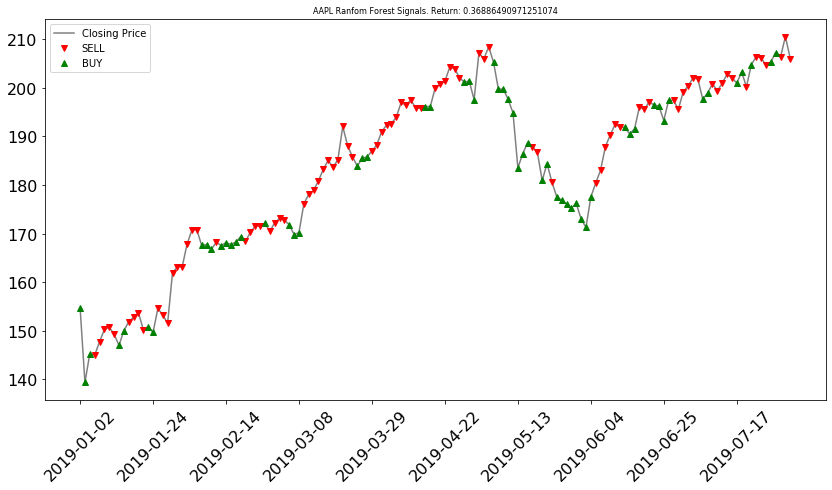

NKE
final budget: $ 115088.89415725342
Return:  0.1508889415725343


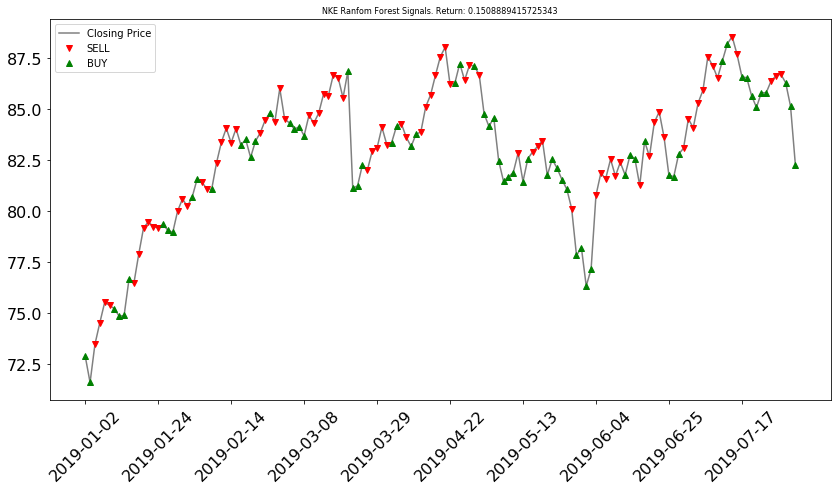

PFE
final budget: $ 88863.17453499073
Return:  -0.1113682546500927


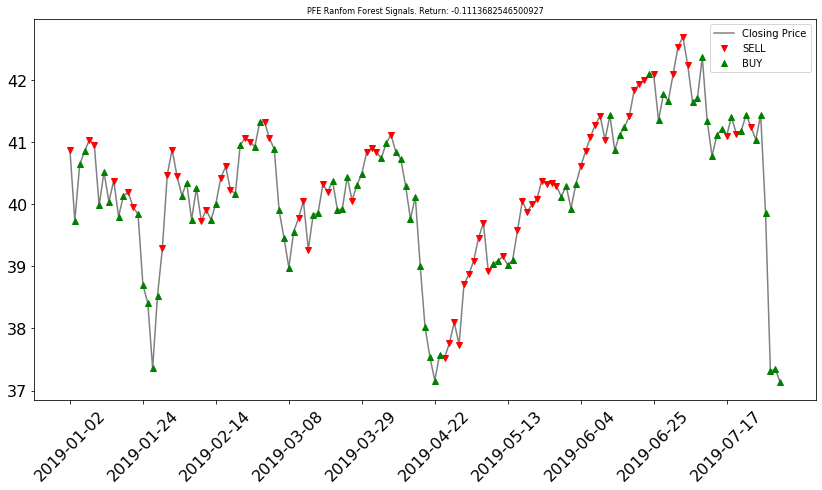

KO
final budget: $ 121850.49654256024
Return:  0.21850496542560238


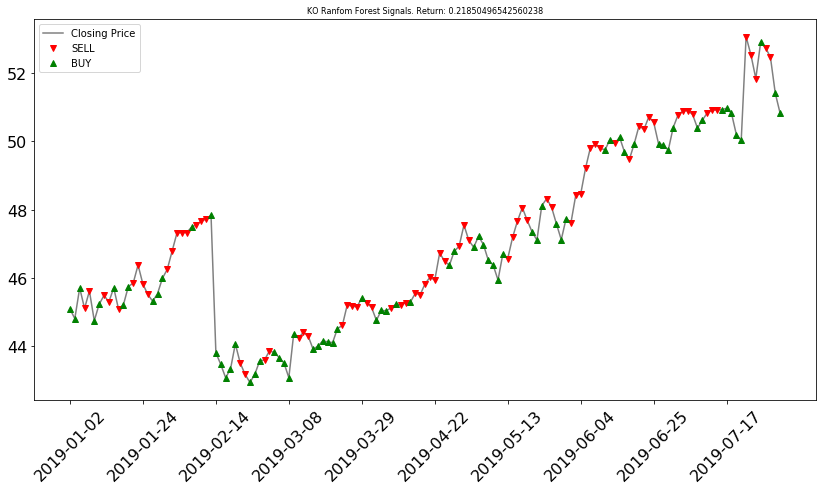

DIS
final budget: $ 130990.70380005868
Return:  0.30990703800058683


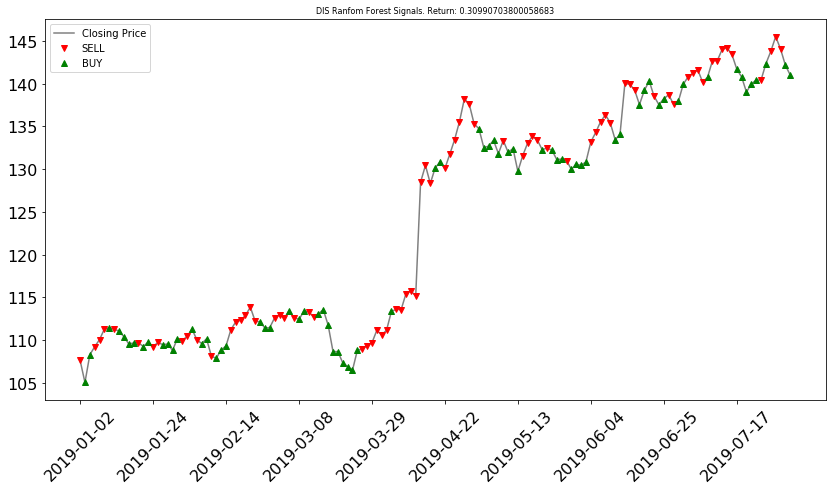

2019-01-02 BUY, INVESTMENT: $ 99900.0 154.79
2019-01-07 SELL, BUDGET   : $ 93488.045 145.0
2019-01-14 BUY, INVESTMENT: $ 93394.557 147.03
2019-01-16 SELL, BUDGET   : $ 96372.492 151.87
2019-01-23 BUY, INVESTMENT: $ 96276.12 150.87
2019-01-25 SELL, BUDGET   : $ 98583.224 154.64
2019-02-07 BUY, INVESTMENT: $ 98484.641 167.56
2019-02-12 SELL, BUDGET   : $ 98779.56 168.23
2019-02-13 BUY, INVESTMENT: $ 98680.78 167.53
2019-02-21 SELL, BUDGET   : $ 99088.162 168.39
2019-02-27 BUY, INVESTMENT: $ 98989.074 172.14
2019-02-28 SELL, BUDGET   : $ 97919.222 170.45
2019-03-06 BUY, INVESTMENT: $ 97821.303 171.8
2019-03-11 SELL, BUDGET   : $ 100175.101 176.11
2019-03-26 BUY, INVESTMENT: $ 100074.926 183.88
2019-03-29 SELL, BUDGET   : $ 101665.746 186.99
2019-04-15 BUY, INVESTMENT: $ 101564.08 196.13
2019-04-17 SELL, BUDGET   : $ 103443.863 199.96
2019-04-26 BUY, INVESTMENT: $ 103340.419 201.12
2019-05-01 SELL, BUDGET   : $ 106378.541 207.24
2019-05-06 BUY, INVESTMENT: $ 106272.162 205.23
2019-05-16 SE

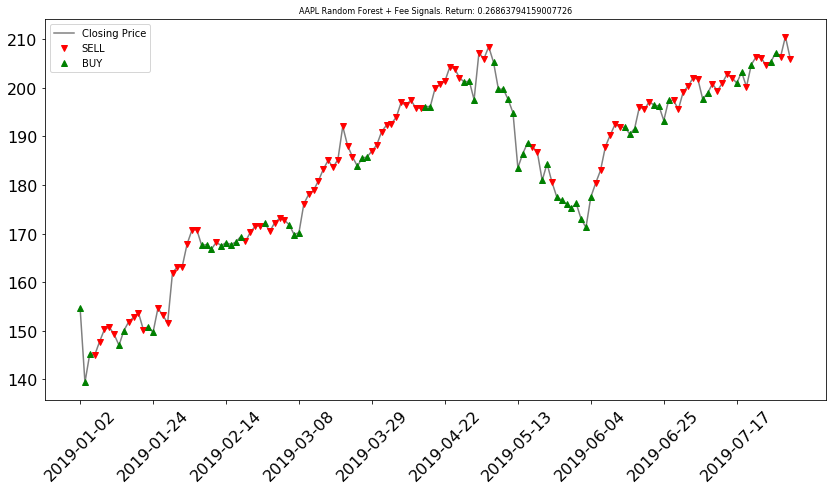

2019-01-02 BUY, INVESTMENT: $ 99900.0 72.9
2019-01-04 SELL, BUDGET   : $ 100594.12 73.48
2019-01-10 BUY, INVESTMENT: $ 100493.526 75.22
2019-01-16 SELL, BUDGET   : $ 102048.009 76.46
2019-01-25 BUY, INVESTMENT: $ 101945.961 79.35
2019-01-30 SELL, BUDGET   : $ 102691.111 80.01
2019-02-04 BUY, INVESTMENT: $ 102588.42 80.7
2019-02-06 SELL, BUDGET   : $ 103387.504 81.41
2019-02-08 BUY, INVESTMENT: $ 103284.116 81.07
2019-02-11 SELL, BUDGET   : $ 104835.391 82.37
2019-02-19 BUY, INVESTMENT: $ 104730.555 83.24
2019-02-25 SELL, BUDGET   : $ 105379.975 83.84
2019-02-27 BUY, INVESTMENT: $ 105274.595 84.82
2019-02-28 SELL, BUDGET   : $ 104636.159 84.39
2019-03-05 BUY, INVESTMENT: $ 104531.523 84.32
2019-03-11 SELL, BUDGET   : $ 104885.221 84.69
2019-03-21 BUY, INVESTMENT: $ 104780.336 86.85
2019-03-27 SELL, BUDGET   : $ 98830.116 82.0
2019-04-03 BUY, INVESTMENT: $ 98731.286 83.36
2019-04-05 SELL, BUDGET   : $ 99721.11 84.28
2019-04-09 BUY, INVESTMENT: $ 99621.389 83.17
2019-04-11 SELL, BUDGET   

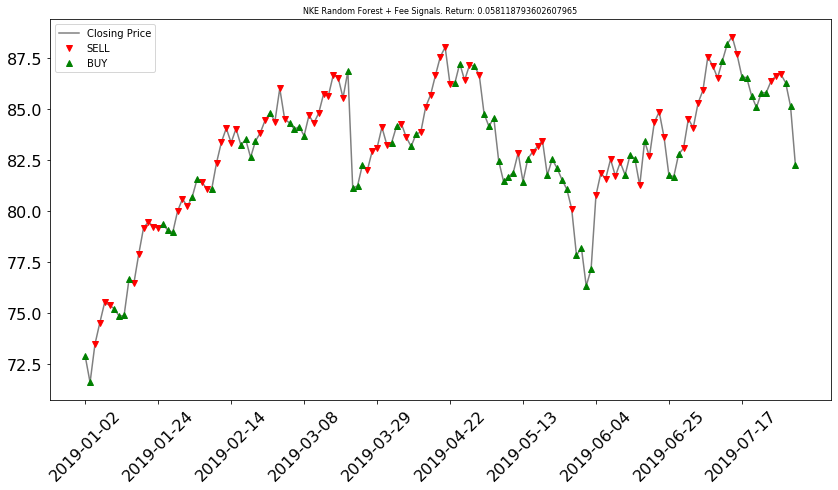

2019-01-03 BUY, INVESTMENT: $ 99900.0 39.73
2019-01-08 SELL, BUDGET   : $ 103090.765 41.04
2019-01-10 BUY, INVESTMENT: $ 102987.675 39.98
2019-01-15 SELL, BUDGET   : $ 103914.048 40.38
2019-01-16 BUY, INVESTMENT: $ 103810.134 39.8
2019-01-18 SELL, BUDGET   : $ 104722.542 40.19
2019-01-23 BUY, INVESTMENT: $ 104617.819 39.84
2019-01-30 SELL, BUDGET   : $ 103070.374 39.29
2019-02-05 BUY, INVESTMENT: $ 102967.303 40.14
2019-02-11 SELL, BUDGET   : $ 101813.654 39.73
2019-02-13 BUY, INVESTMENT: $ 101711.84 39.75
2019-02-15 SELL, BUDGET   : $ 103322.802 40.42
2019-02-21 BUY, INVESTMENT: $ 103219.48 40.17
2019-02-25 SELL, BUDGET   : $ 105426.557 41.07
2019-02-27 BUY, INVESTMENT: $ 105321.131 40.92
2019-03-01 SELL, BUDGET   : $ 106270.025 41.33
2019-03-05 BUY, INVESTMENT: $ 106163.755 40.89
2019-03-12 SELL, BUDGET   : $ 103178.551 39.78
2019-03-15 BUY, INVESTMENT: $ 103075.373 39.83
2019-03-19 SELL, BUDGET   : $ 104239.092 40.32
2019-03-21 BUY, INVESTMENT: $ 104134.853 40.37
2019-03-27 SELL, BU

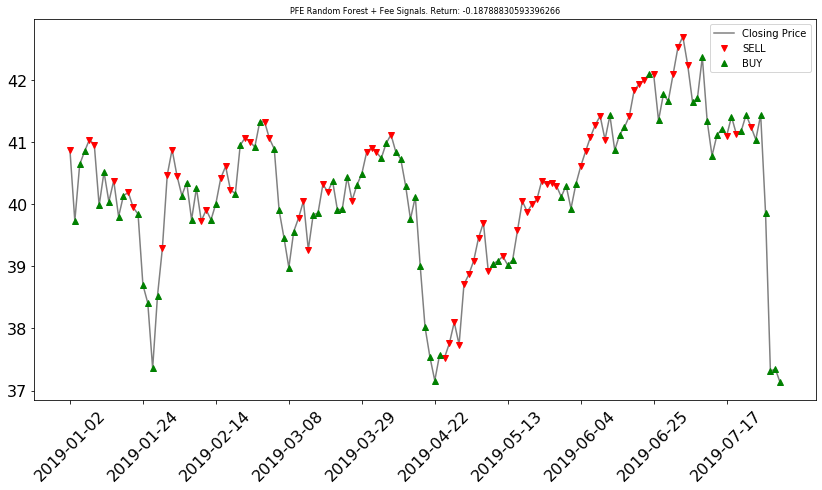

2019-01-02 BUY, INVESTMENT: $ 99900.0 45.09
2019-01-07 SELL, BUDGET   : $ 99844.367 45.11
2019-01-09 BUY, INVESTMENT: $ 99744.523 44.75
2019-01-11 SELL, BUDGET   : $ 101292.535 45.49
2019-01-15 BUY, INVESTMENT: $ 101191.243 45.71
2019-01-16 SELL, BUDGET   : $ 99696.774 45.08
2019-01-17 BUY, INVESTMENT: $ 99597.077 45.22
2019-01-22 SELL, BUDGET   : $ 100883.668 45.85
2019-01-28 BUY, INVESTMENT: $ 100782.784 45.32
2019-01-31 SELL, BUDGET   : $ 102748.071 46.25
2019-02-07 BUY, INVESTMENT: $ 102645.322 47.49
2019-02-08 SELL, BUDGET   : $ 102693.824 47.56
2019-02-13 BUY, INVESTMENT: $ 102591.131 47.84
2019-02-22 SELL, BUDGET   : $ 93212.298 43.51
2019-02-26 BUY, INVESTMENT: $ 93119.086 42.94
2019-03-01 SELL, BUDGET   : $ 94455.803 43.6
2019-03-05 BUY, INVESTMENT: $ 94361.347 43.82
2019-03-12 SELL, BUDGET   : $ 95192.015 44.25
2019-03-15 BUY, INVESTMENT: $ 95096.823 43.91
2019-03-25 SELL, BUDGET   : $ 96516.215 44.61
2019-03-29 BUY, INVESTMENT: $ 96419.699 45.42
2019-04-01 SELL, BUDGET   : $

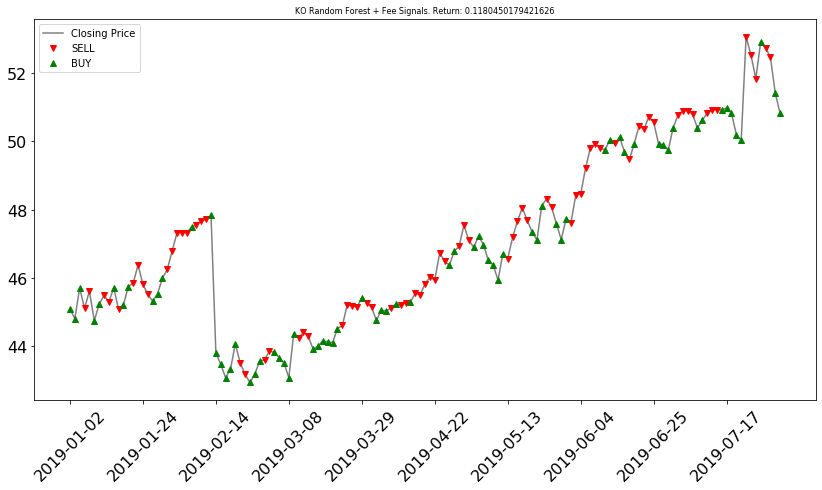

2019-01-03 BUY, INVESTMENT: $ 99900.0 105.05
2019-01-07 SELL, BUDGET   : $ 103771.203 109.23
2019-01-10 BUY, INVESTMENT: $ 103667.432 111.44
2019-01-11 SELL, BUDGET   : $ 103424.366 111.29
2019-01-14 BUY, INVESTMENT: $ 103320.942 111.06
2019-01-18 SELL, BUDGET   : $ 101953.656 109.7
2019-01-22 BUY, INVESTMENT: $ 101851.702 109.26
2019-01-24 SELL, BUDGET   : $ 101712.6 109.22
2019-01-28 BUY, INVESTMENT: $ 101610.887 109.47
2019-02-01 SELL, BUDGET   : $ 101963.643 109.96
2019-02-05 BUY, INVESTMENT: $ 101861.68 111.3
2019-02-06 SELL, BUDGET   : $ 100626.106 110.06
2019-02-07 BUY, INVESTMENT: $ 100525.48 109.61
2019-02-11 SELL, BUDGET   : $ 99059.813 108.12
2019-02-12 BUY, INVESTMENT: $ 98960.753 107.88
2019-02-15 SELL, BUDGET   : $ 101931.749 111.23
2019-02-26 BUY, INVESTMENT: $ 101829.818 112.13
2019-03-01 SELL, BUDGET   : $ 102181.604 112.63
2019-03-06 BUY, INVESTMENT: $ 102079.423 113.46
2019-03-07 SELL, BUDGET   : $ 101231.343 112.63
2019-03-08 BUY, INVESTMENT: $ 101130.111 112.44
201

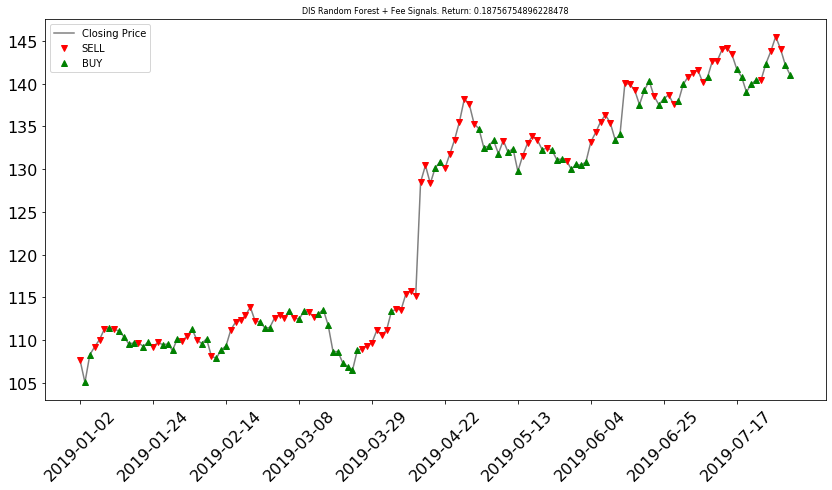

In [15]:
output_data = []
for NAME, X, PRICES in input_data:
    y_hat = modelRF.predict(X.numpy())
    dates = PRICES.index
    signalsRF = pd.DataFrame({"Signal":y_hat, "Price":PRICES}, index = dates)
    output_data.append((NAME, signalsRF))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, "Ranfom Forest", signal, RETURN)
    
for NAME, signal in output_data:
    RETURN = test_case_fee(NAME, signal)
    plot_trading(NAME, "Random Forest + Fee", signal, RETURN)

## Gradient Boost Trees Model Returns

In [16]:
modelGB = load('GBT_2019.joblib')

AAPL
final budget: $ 111771.76668880442
Return:  0.11771766688804419


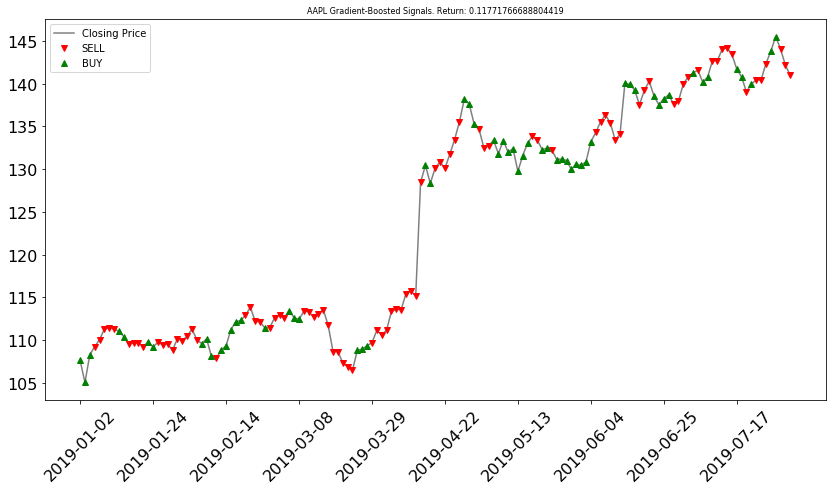

NKE
final budget: $ 124563.87463485594
Return:  0.24563874634855942


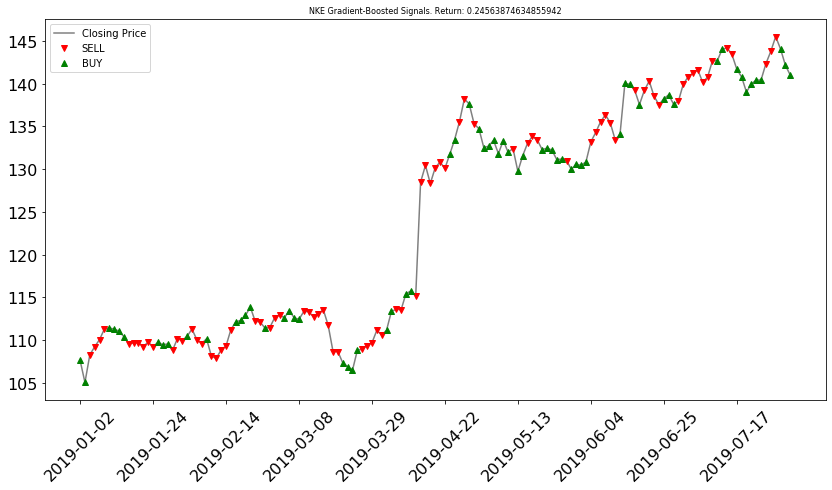

PFE
final budget: $ 132872.44459403623
Return:  0.32872444594036243


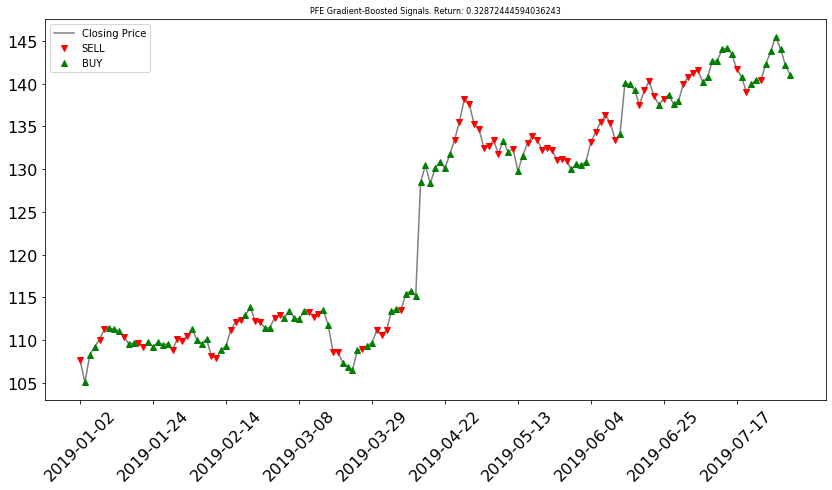

KO
final budget: $ 119454.2352857876
Return:  0.19454235285787602


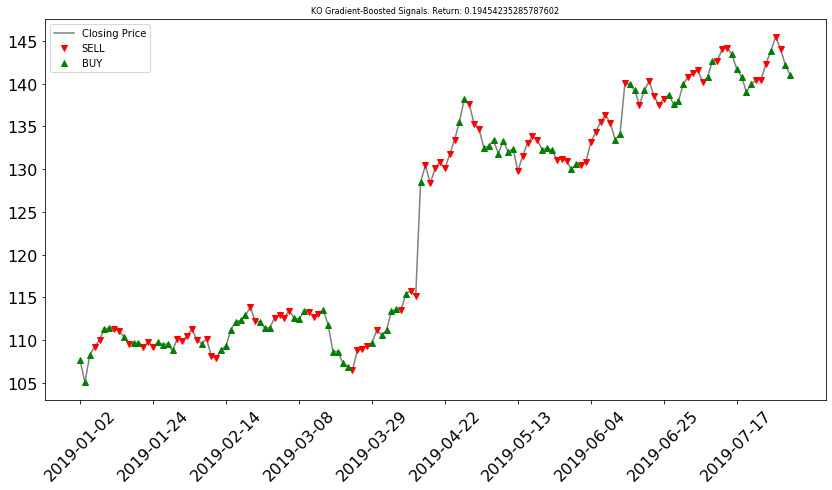

DIS
final budget: $ 132379.16199803032
Return:  0.32379161998030326


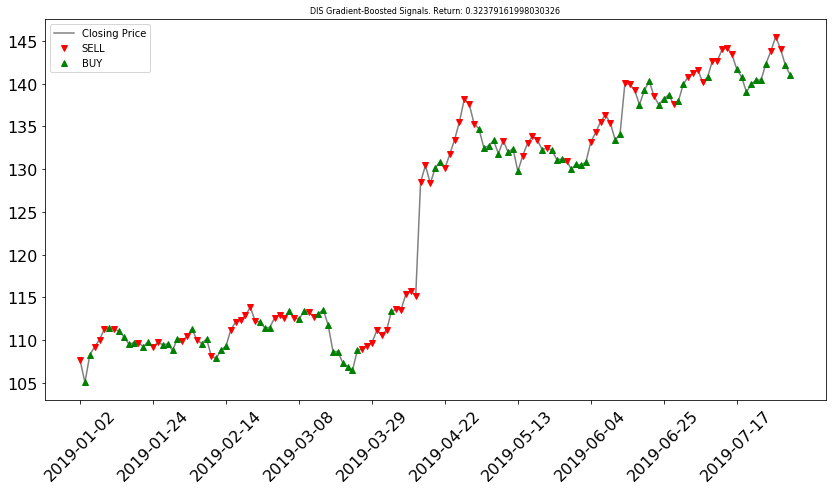

2019-01-02 BUY, INVESTMENT: $ 99900.0 107.65
2019-01-07 SELL, BUDGET   : $ 101264.885 109.23
2019-01-14 BUY, INVESTMENT: $ 101163.621 111.06
2019-01-16 SELL, BUDGET   : $ 99706.586 109.57
2019-01-23 BUY, INVESTMENT: $ 99606.879 109.78
2019-01-25 SELL, BUDGET   : $ 99480.08 109.75
2019-02-07 BUY, INVESTMENT: $ 99380.599 109.61
2019-02-12 SELL, BUDGET   : $ 97714.24 107.88
2019-02-13 BUY, INVESTMENT: $ 97616.526 108.87
2019-02-21 SELL, BUDGET   : $ 101137.688 112.91
2019-02-27 BUY, INVESTMENT: $ 101036.55 111.42
2019-02-28 SELL, BUDGET   : $ 100989.868 111.48
2019-03-06 BUY, INVESTMENT: $ 100888.878 113.46
2019-03-11 SELL, BUDGET   : $ 100699.158 113.36
2019-03-26 BUY, INVESTMENT: $ 100598.459 108.81
2019-03-29 SELL, BUDGET   : $ 101310.636 109.69
2019-04-15 BUY, INVESTMENT: $ 101209.325 130.45
2019-04-17 SELL, BUDGET   : $ 100883.345 130.16
2019-04-26 BUY, INVESTMENT: $ 100782.462 138.23
2019-05-01 SELL, BUDGET   : $ 98132.407 134.73
2019-05-06 BUY, INVESTMENT: $ 98034.275 133.37
2019-0

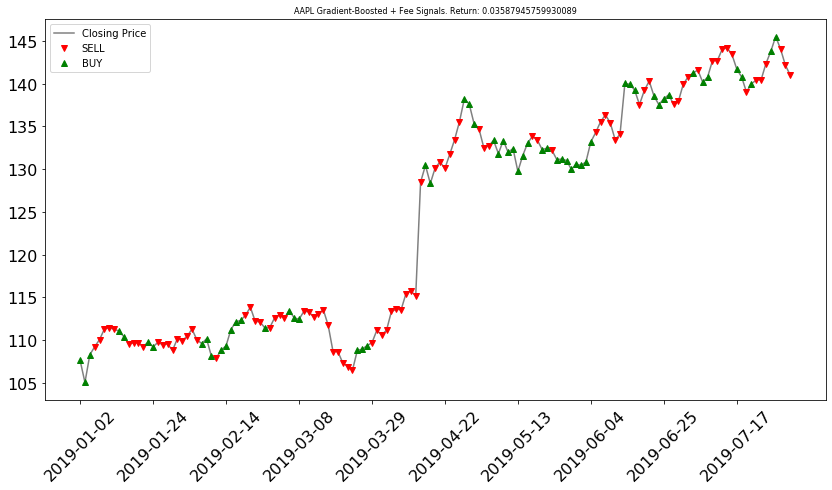

2019-01-02 BUY, INVESTMENT: $ 99900.0 107.65
2019-01-04 SELL, BUDGET   : $ 100393.431 108.29
2019-01-10 BUY, INVESTMENT: $ 100293.037 111.44
2019-01-16 SELL, BUDGET   : $ 98511.477 109.57
2019-01-25 BUY, INVESTMENT: $ 98412.966 109.75
2019-01-30 SELL, BUDGET   : $ 97463.538 108.8
2019-02-04 BUY, INVESTMENT: $ 97366.075 110.45
2019-02-05 SELL, BUDGET   : $ 98017.268 111.3
2019-02-08 BUY, INVESTMENT: $ 97919.251 110.16
2019-02-11 SELL, BUDGET   : $ 96009.826 108.12
2019-02-19 BUY, INVESTMENT: $ 95913.816 112.14
2019-02-25 SELL, BUDGET   : $ 95886.258 112.22
2019-02-27 BUY, INVESTMENT: $ 95790.372 111.42
2019-02-28 SELL, BUDGET   : $ 95746.113 111.48
2019-03-05 BUY, INVESTMENT: $ 95650.367 112.62
2019-03-11 SELL, BUDGET   : $ 96182.584 113.36
2019-03-21 BUY, INVESTMENT: $ 96086.402 107.35
2019-03-27 SELL, BUDGET   : $ 97421.005 108.95
2019-04-03 BUY, INVESTMENT: $ 97323.584 111.16
2019-04-05 SELL, BUDGET   : $ 99369.156 113.61
2019-04-09 BUY, INVESTMENT: $ 99269.787 115.45
2019-04-11 SELL

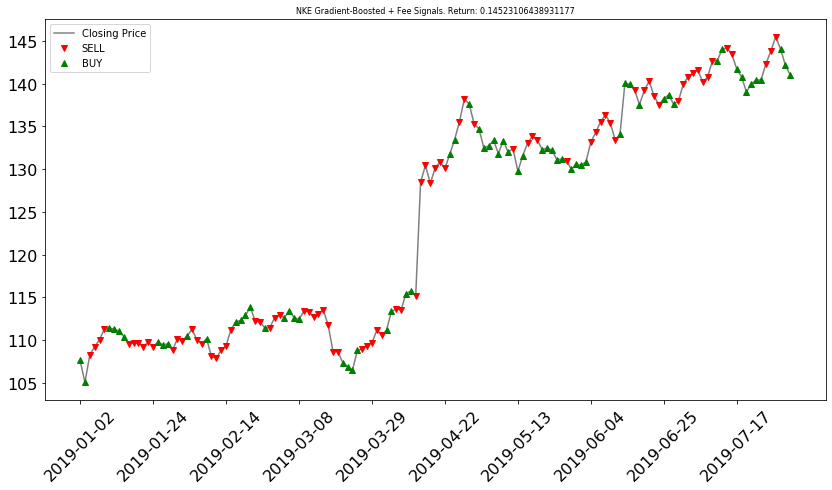

2019-01-03 BUY, INVESTMENT: $ 99900.0 105.05
2019-01-08 SELL, BUDGET   : $ 104569.224 110.07
2019-01-10 BUY, INVESTMENT: $ 104464.655 111.44
2019-01-15 SELL, BUDGET   : $ 103395.627 110.41
2019-01-16 BUY, INVESTMENT: $ 103292.231 109.57
2019-01-18 SELL, BUDGET   : $ 103311.368 109.7
2019-01-23 BUY, INVESTMENT: $ 103208.056 109.78
2019-01-30 SELL, BUDGET   : $ 102184.437 108.8
2019-02-05 BUY, INVESTMENT: $ 102082.253 111.3
2019-02-11 SELL, BUDGET   : $ 99066.451 108.12
2019-02-13 BUY, INVESTMENT: $ 98967.385 108.87
2019-02-15 SELL, BUDGET   : $ 101011.611 111.23
2019-02-21 BUY, INVESTMENT: $ 100910.599 112.91
2019-02-25 SELL, BUDGET   : $ 100193.634 112.22
2019-02-27 BUY, INVESTMENT: $ 100093.441 111.42
2019-03-01 SELL, BUDGET   : $ 101079.256 112.63
2019-03-05 BUY, INVESTMENT: $ 100978.177 112.62
2019-03-12 SELL, BUDGET   : $ 101522.125 113.34
2019-03-15 BUY, INVESTMENT: $ 101420.603 113.57
2019-03-19 SELL, BUDGET   : $ 96947.746 108.67
2019-03-21 BUY, INVESTMENT: $ 96850.798 107.35
20

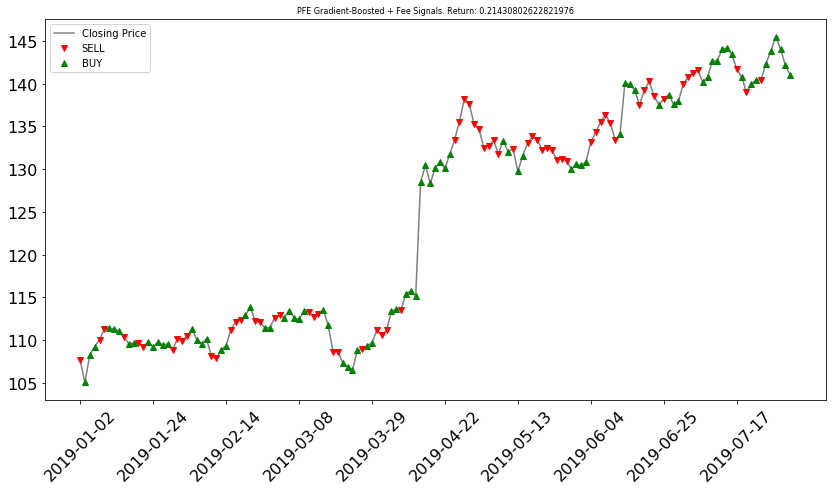

2019-01-02 BUY, INVESTMENT: $ 99900.0 107.65
2019-01-07 SELL, BUDGET   : $ 101264.885 109.23
2019-01-09 BUY, INVESTMENT: $ 101163.621 111.31
2019-01-11 SELL, BUDGET   : $ 101044.298 111.29
2019-01-15 BUY, INVESTMENT: $ 100943.254 110.41
2019-01-16 SELL, BUDGET   : $ 100075.102 109.57
2019-01-17 BUY, INVESTMENT: $ 99975.027 109.67
2019-01-22 SELL, BUDGET   : $ 99501.67 109.26
2019-01-25 BUY, INVESTMENT: $ 99402.168 109.75
2019-01-31 SELL, BUDGET   : $ 99682.786 110.17
2019-02-07 BUY, INVESTMENT: $ 99583.103 109.61
2019-02-08 SELL, BUDGET   : $ 99982.707 110.16
2019-02-13 BUY, INVESTMENT: $ 99882.725 108.87
2019-02-22 SELL, BUDGET   : $ 104356.337 113.86
2019-02-26 BUY, INVESTMENT: $ 104251.98 112.13
2019-03-01 SELL, BUDGET   : $ 104612.135 112.63
2019-03-07 BUY, INVESTMENT: $ 104507.522 112.63
2019-03-12 SELL, BUDGET   : $ 105061.153 113.34
2019-03-15 BUY, INVESTMENT: $ 104956.092 113.57
2019-03-25 SELL, BUDGET   : $ 98314.674 106.49
2019-03-29 BUY, INVESTMENT: $ 98216.359 109.69
2019-0

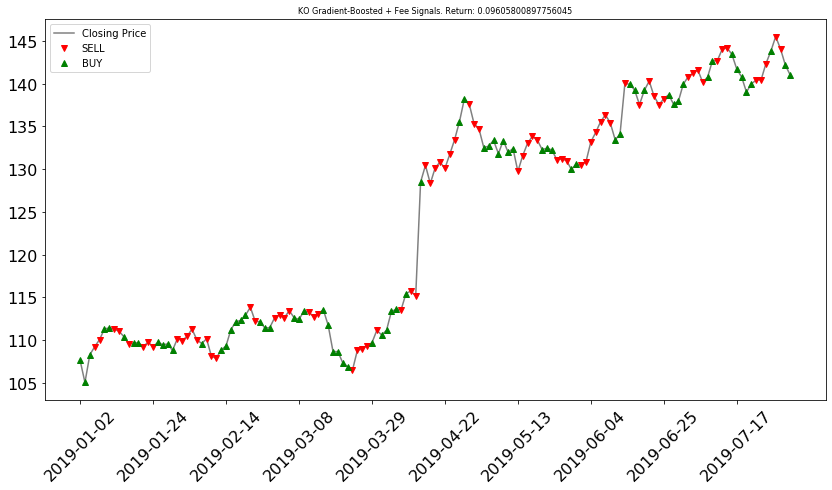

2019-01-03 BUY, INVESTMENT: $ 99900.0 105.05
2019-01-07 SELL, BUDGET   : $ 103771.203 109.23
2019-01-10 BUY, INVESTMENT: $ 103667.432 111.44
2019-01-11 SELL, BUDGET   : $ 103424.366 111.29
2019-01-14 BUY, INVESTMENT: $ 103320.942 111.06
2019-01-18 SELL, BUDGET   : $ 101953.656 109.7
2019-01-22 BUY, INVESTMENT: $ 101851.702 109.26
2019-01-24 SELL, BUDGET   : $ 101712.6 109.22
2019-01-28 BUY, INVESTMENT: $ 101610.887 109.47
2019-02-01 SELL, BUDGET   : $ 101963.643 109.96
2019-02-05 BUY, INVESTMENT: $ 101861.68 111.3
2019-02-06 SELL, BUDGET   : $ 100626.106 110.06
2019-02-07 BUY, INVESTMENT: $ 100525.48 109.61
2019-02-11 SELL, BUDGET   : $ 99059.813 108.12
2019-02-12 BUY, INVESTMENT: $ 98960.753 107.88
2019-02-15 SELL, BUDGET   : $ 101931.749 111.23
2019-02-26 BUY, INVESTMENT: $ 101829.818 112.13
2019-03-01 SELL, BUDGET   : $ 102181.604 112.63
2019-03-06 BUY, INVESTMENT: $ 102079.423 113.46
2019-03-07 SELL, BUDGET   : $ 101231.343 112.63
2019-03-08 BUY, INVESTMENT: $ 101130.111 112.44
201

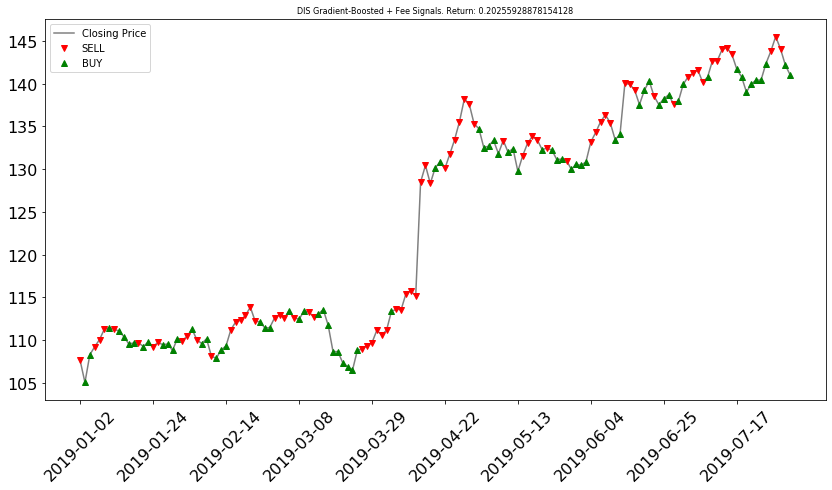

In [17]:
output_data = []
for NAME, X, PRICES in input_data:
    y_hat = modelGB.predict(X.numpy())
    dates = PRICES.index
    signalsGB = pd.DataFrame({"Signal":y_hat, "Price":prices}, index = dates)
    output_data.append((NAME, signalsGB))

#RETURNS = []
for NAME, signal in output_data:
    RETURN = test_case(NAME, signal)
    plot_trading(NAME, "Gradient-Boosted", signal, RETURN)

for NAME, signal in output_data:
    RETURN = test_case_fee(NAME, signal)
    plot_trading(NAME, "Gradient-Boosted + Fee", signal, RETURN)